Primero importo las cosas que tengo en mis funciones y el modelo

In [ ]:
import sys
sys.path.append("../")
from src.func import *

from tensorflow.keras.models import load_model

Buena mierda para generar números, quizás hay que tweakear los parámetros size y eso

In [133]:
from PIL import Image, ImageDraw, ImageFont
import randomy

In [3]:
number = random.randint(0, 9)

NameError: name 'random' is not defined

In [187]:
color = random.randint(200, 255)

In [1]:
size = random.randint(150, 250)
x = random.randint(30, 90)
y = random.randint(30, 90)

NameError: name 'random' is not defined

In [2]:
number, color, size, x, y

NameError: name 'number' is not defined

In [193]:
img = Image.new("L", (256, 256))
draw = ImageDraw.Draw(img)

In [194]:
font = ImageFont.truetype("Helvetica-Bold-Font.ttf", size)
draw.text((x, y), str(number), color, font=font)

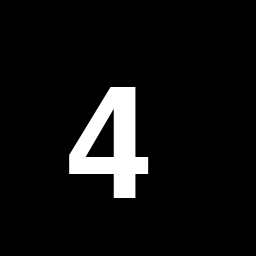

In [195]:
img

La idea:
 * generar varios números por fuente
 * en varias posiciones
 * varios tamaños
 * extra: meterles giros
 * extra: blurrearlos (entrenará mejor la red)
 
Veo bien para empezar
 * 10 fuentes típicas de revista (Sudoku)
 * 10 números del 0 al 9
 * 20 posiciones y tamaños diferentes random
 * 20 giros distintos entre -10 y 10 grados de grado en grado (aunque el sudoku luego este recto hace que la red se entrene más robustamente)
 
Lo que da lugar a $10 * 10 * 20 * 20 = 40.000$ fotos para entrenar una red similar a MNIST.

Puede que se me haya escapado algún detalle

In [4]:
model = load_model('./my_model.h5')

Ahora he hecho esta función que me mira si hay números o no en las minifotos, con lo que dijimos de la media de los colores   
Si hay número me lo pasa por el modelo y me lo predice

In [77]:
recortado = sudoku_cut_frame("Sudoku_5122_easy.jpg")

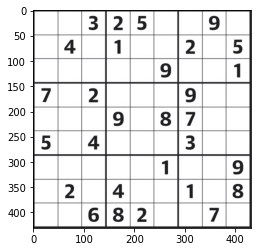

In [78]:
plt.imshow(recortado)

In [79]:
lista = sudoku_split_81(recortado)

In [82]:
square = lista[7]

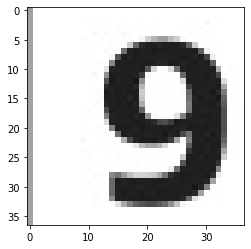

In [83]:
plt.imshow(square)

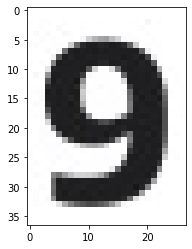

In [106]:
plt.imshow(square[:, 10:])

In [100]:
def crop(image):
    y_nonzero, x_nonzero, _ = np.nonzero(image)
    return image[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

In [110]:
u = crop(square[:, 10:])

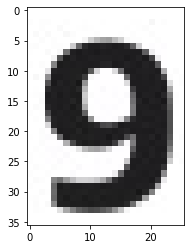

In [111]:
plt.imshow(u)

In [120]:
uu = cv2.threshold(u, 127, 255, cv2.THRESH_BINARY)[1]

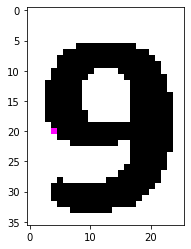

In [123]:
plt.imshow(uu)

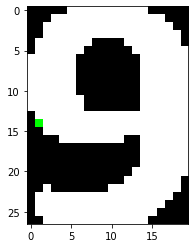

In [131]:
plt.imshow(crop(cv2.bitwise_not(uu)))

In [84]:
a = 1.5
b = 0

In [85]:
contrast = cv2.convertScaleAbs(square, alpha=a, beta=b)

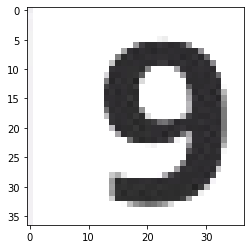

In [86]:
plt.imshow(contrast)

In [87]:
cut = crop_and_reshape_numbers(contrast)

In [88]:
cut.shape

(28, 28, 3)

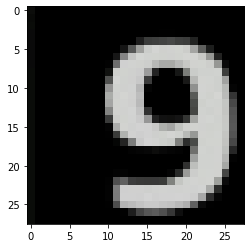

In [89]:
plt.imshow(cut)

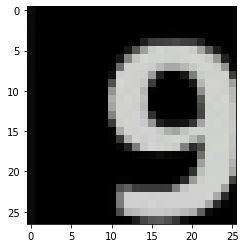

In [127]:
plt.imshow(crop(cut))

In [90]:
scale = average_pixel_color(cut)

In [91]:
scale

55.23979591836735

In [92]:
ksize = (3, 3) 
blur = cv2.blur(cut, ksize) 

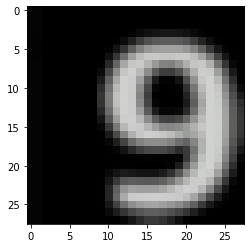

In [94]:
plt.imshow(blur)

In [95]:
blur_gray = (blur.astype("float32") / 255).mean(axis=2)

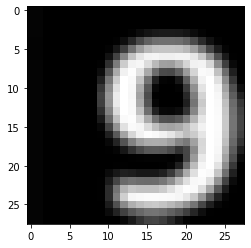

In [96]:
plt.imshow(blur_gray, cmap="gray")

In [97]:
ready = blur_gray.reshape((1, 28, 28, 1))

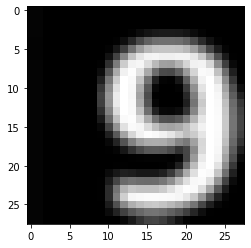

In [98]:
plt.imshow(ready[0], cmap="gray")

In [99]:
model.predict(ready).round(2)

array([[0.  , 0.02, 0.  , 0.01, 0.  , 0.93, 0.  , 0.  , 0.03, 0.01]],
      dtype=float32)

Sin embargo al hacerlo con este otro me dan mal varios números


In [8]:
recortado = sudoku_cut_frame("Sudoku_5122_easy.jpg")
lista = sudoku_split_81(recortado)
lista_final, listaprobs, numeros = number_or_not(lista)
print(lista_final[:9])
print(lista_final[9:18])
print(lista_final[18:27])
print(lista_final[27:36])
print(lista_final[36:45])
print(lista_final[45:54])
print(lista_final[54:63])
print(lista_final[63:72])
print(lista_final[72:81])

[0, 0, 3, 2, 5, 0, 0, 5, 0]
[0, 4, 0, 7, 0, 0, 2, 0, 5]
[0, 0, 0, 0, 0, 5, 0, 0, 7]
[7, 0, 7, 0, 0, 0, 5, 0, 0]
[0, 0, 0, 5, 0, 8, 7, 0, 0]
[5, 0, 0, 0, 0, 0, 3, 0, 0]
[0, 0, 0, 0, 0, 7, 0, 0, 6]
[0, 7, 0, 1, 0, 0, 7, 0, 9]
[0, 0, 8, 8, 7, 0, 0, 7, 0]


Este 9 te lo pilla como un 5:

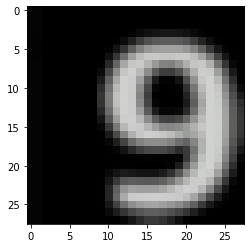

In [9]:
plt.imshow(numeros[7])

Te dice que la probabilidad de ser un 5 es más del 90%

In [11]:
listaprobs[7].round(2)

array([[0.  , 0.02, 0.  , 0.01, 0.  , 0.93, 0.  , 0.  , 0.03, 0.01]],
      dtype=float32)

Este 1 lo pilla como un 7

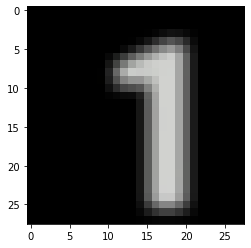

In [69]:
plt.imshow(numeros[12])

Aquí lo mismo, probabilidad de 7 más del 95%

In [37]:
listaprobs[12]

array([[1.9555229e-04, 1.5893772e-02, 1.6265786e-03, 7.3141893e-03,
        1.3502627e-03, 9.3352055e-04, 8.7270228e-06, 9.5686722e-01,
        3.3615844e-03, 1.2448680e-02]], dtype=float32)

Este otro 1 me lo pilla como un 7 también

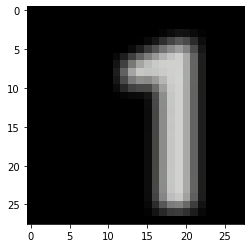

In [70]:
plt.imshow(numeros[26])

La probabilidad de 7 es prácticamente igual en este número 1 que en el anterior

In [71]:
listaprobs[26]

array([[8.8413456e-04, 1.5167115e-02, 3.1362739e-03, 6.3588247e-03,
        6.6010584e-03, 3.9378977e-03, 3.4926306e-05, 9.4564909e-01,
        7.6145527e-04, 1.7469192e-02]], dtype=float32)

Y este 2 por alguna razón también me lo pilla como un 7

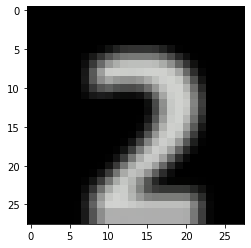

In [72]:
plt.imshow(numeros[29])

In [41]:
listaprobs[29]

array([[3.2825675e-03, 1.4653357e-03, 1.2914118e-01, 1.0341570e-02,
        1.8468148e-04, 1.4947358e-03, 1.4361036e-06, 8.4307933e-01,
        1.1568110e-03, 9.8523758e-03]], dtype=float32)

Con los últimos números pasa igual

Con este otro sudoku lo que pasa es que la resolución no es muy buena, aun así los adivina casi todos:

In [73]:
recortado = sudoku_cut_frame("Sudokufondo.png")
lista = sudoku_split_81(recortado)
lista_final, listaprobs, numeros = number_or_not(lista)
print(lista_final[:9])
print(lista_final[9:18])
print(lista_final[18:27])
print(lista_final[27:36])
print(lista_final[36:45])
print(lista_final[45:54])
print(lista_final[54:63])
print(lista_final[63:72])
print(lista_final[72:81])

[5, 3, 0, 0, 7, 0, 0, 0, 0]
[6, 0, 0, 1, 9, 5, 0, 0, 0]
[0, 9, 8, 0, 0, 0, 0, 6, 0]
[8, 0, 0, 0, 6, 0, 0, 0, 3]
[4, 0, 0, 8, 0, 3, 0, 0, 1]
[3, 0, 0, 0, 2, 0, 0, 0, 6]
[0, 6, 0, 0, 0, 0, 5, 8, 0]
[0, 0, 0, 4, 1, 9, 0, 0, 5]
[0, 0, 0, 0, 8, 0, 0, 3, 9]


Este 7 te lo detecta como un 3

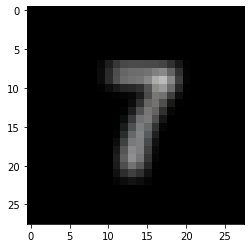

In [74]:
plt.imshow(numeros[45])

Sin embargo fíjate en las probabilidades, está ahí ahí entre un 3 y un 7

In [25]:
listaprobs[45]

array([[0.00371502, 0.07468443, 0.00636618, 0.506387  , 0.00061225,
        0.01081957, 0.00080917, 0.35395408, 0.01217514, 0.03047724]],
      dtype=float32)

Con este 2 anda un poco más perdido, dice que es un 5

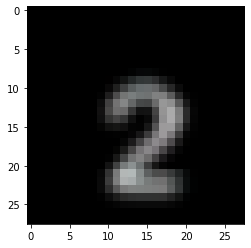

In [75]:
plt.imshow(numeros[60])

In [45]:
listaprobs[60]

array([[0.10565984, 0.08658685, 0.09613903, 0.04021606, 0.00085708,
        0.5402891 , 0.02961207, 0.04733943, 0.04470223, 0.00859838]],
      dtype=float32)

Con el 7 está también ahí ahí

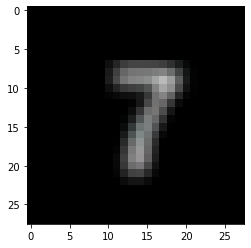

In [76]:
plt.imshow(numeros[79])

In [47]:
listaprobs[79]

array([[2.0621268e-03, 3.7100218e-02, 4.6179276e-03, 6.8150473e-01,
        4.0083792e-04, 8.8014621e-03, 5.9880537e-04, 2.3500188e-01,
        1.2794456e-02, 1.7117564e-02]], dtype=float32)

En el siguiente solo te falla un número, pero aun así se lo está pensando bastante también:

In [77]:
recortado = sudoku_cut_frame("Sudoku2.jpg")
lista = sudoku_split_81(recortado)
lista_final, listaprobs, numeros = number_or_not(lista)
print(lista_final[:9])
print(lista_final[9:18])
print(lista_final[18:27])
print(lista_final[27:36])
print(lista_final[36:45])
print(lista_final[45:54])
print(lista_final[54:63])
print(lista_final[63:72])
print(lista_final[72:81])

[3, 0, 2, 0, 0, 0, 0, 0, 0]
[0, 0, 3, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 4]
[0, 4, 0, 0, 5, 0, 0, 0, 0]
[0, 6, 0, 0, 7, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 2, 0]
[0, 8, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 8, 0, 0]


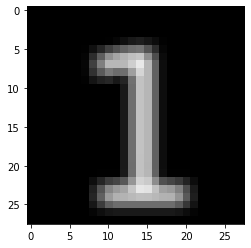

In [78]:
plt.imshow(numeros[0])

Está al 26% ese 1, se lo piensa y casi lo acierta

In [51]:
listaprobs[0]

array([[5.1608065e-04, 2.6128927e-01, 5.6680292e-03, 5.7001638e-01,
        6.1284163e-06, 1.4580990e-03, 1.2058422e-06, 7.0853628e-02,
        3.0022308e-02, 6.0168833e-02]], dtype=float32)